In [3]:
import zipfile
import os

# Unzip file
zip_path = "/content/Orig_Image-20260130T163620Z-3-001.zip"  # Corrected zip file path
output_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

# Check extracted folder
print("Extracted files:")
!ls -lh /content/

Extracted files:
total 391M
drwxr-xr-x 2 root root  16M Feb  3 09:04 annotations
drwxr-xr-x 2 root root  40K Feb  3 09:12 images
drwxr-xr-x 2 root root  72K Feb  3 09:14 Orig_Image
-rw-r--r-- 1 root root 376M Feb  3 09:11 Orig_Image-20260130T163620Z-3-001.zip
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data


### Step 1 - Install + Download + Extract Data

In [1]:
!pip install -q transformers datasets torch torchvision Pillow PyMuPDF huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 82.7 MB/s eta 0:00:00


In [2]:
import tarfile
import os
from huggingface_hub import hf_hub_download

# Create folders
os.makedirs("/content/annotations", exist_ok=True)
os.makedirs("/content/images", exist_ok=True)


# Download + extract annotations
print("Downloading annotations...")

ann_path = hf_hub_download(
    repo_id="bsmock/pubtables-1m",
    filename="PubTables-1M-Detection_Annotations_Train.tar.gz",
    repo_type="dataset"
)

with tarfile.open(ann_path, "r:gz") as tar:
    tar.extractall("/content/annotations")

print("✓ Annotations extracted")


# Download + extract 0.5% images
print("\nDownloading images Part1...")

img_path = hf_hub_download(
    repo_id="bsmock/pubtables-1m",
    filename="PubTables-1M-Detection_Images_Train_Part1.tar.gz",
    repo_type="dataset"
)

with tarfile.open(img_path, "r:gz") as tar:
    members = tar.getmembers()
    half = int(len(members) * 0.005)   # take 0.5%
    tar.extractall("/content/images", members=members[:half])

print("✓ 50% Images extracted")

print("\n✅ Done!")
print("Annotations folder: /content/annotations/")
print("Images folder: /content/images/")


PubTables-1M-Detection_Annotations_Train(…):   0%|          | 0.00/40.1M [00:00<?, ?B/s]

/tmp/ipython-input-1205365836.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("/content/annotations")


✓ Annotations extracted



PubTables-1M-Detection_Images_Train_Part(…):   0%|          | 0.00/30.8G [00:00<?, ?B/s]

/tmp/ipython-input-1205365836.py:41: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("/content/images", members=members[:half])


✓ 50% Images extracted

✅ Done!
Annotations folder: /content/annotations/
Images folder: /content/images/


### Step 2 - Check Folders

In [4]:
import os

# Check annotations folder structure
print("Annotations folder:")
for root, dirs, files in os.walk("/content/annotations"):
    level = root.replace("/content/annotations", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        subindent = " " * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

# Check images folder
print("\nImages folder:")
for root, dirs, files in os.walk("/content/images"):
    level = root.replace("/content/images", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        subindent = " " * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

Annotations folder:
annotations/
  PMC2964653_2.xml
  PMC6349021_3.xml
  PMC4591700_6.xml
  PMC5007825_4.xml
  PMC4935870_2.xml
  ... and 460584 more files

Images folder:
images/
  PMC3670201_1.jpg
  PMC2752806_5.jpg
  PMC4472807_5.jpg
  PMC3549748_3.jpg
  PMC4370585_6.jpg
  ... and 1146 more files


### Step 3 - Set Correct Paths

In [5]:
import os
import glob

# Find actual image and annotation paths
# subfolder name may differ after extraction
img_files = glob.glob("/content/images/**/*.png", recursive=True) + \
            glob.glob("/content/images/**/*.jpg", recursive=True)
xml_files = glob.glob("/content/annotations/**/*.xml", recursive=True)

IMG_DIR = os.path.dirname(img_files[0]) if img_files else "/content/images"
ANN_DIR = os.path.dirname(xml_files[0]) if xml_files else "/content/annotations"

print(f"IMG_DIR: {IMG_DIR}")
print(f"ANN_DIR: {ANN_DIR}")
print(f"Total images found: {len(img_files)}")
print(f"Total XMLs found: {len(xml_files)}")

IMG_DIR: /content/images
ANN_DIR: /content/annotations
Total images found: 1151
Total XMLs found: 460589


### Step 4 - Read Annotations + Create Data List

In [6]:
import os
import xml.etree.ElementTree as ET

def read_boxes(xml_path):
    root = ET.parse(xml_path).getroot()
    boxes = []
    for obj in root.findall("object"):
        b = obj.find("bndbox")
        xmin = int(float(b.find("xmin").text))
        ymin = int(float(b.find("ymin").text))
        xmax = int(float(b.find("xmax").text))
        ymax = int(float(b.find("ymax").text))
        boxes.append([xmin, ymin, xmax - xmin, ymax - ymin])  # [x, y, w, h]
    return boxes

data = []
for img_file in os.listdir(IMG_DIR)[:500]:
    img_name = os.path.splitext(img_file)[0]
    xml_path = os.path.join(ANN_DIR, img_name + ".xml")
    if not os.path.exists(xml_path):
        continue
    boxes = read_boxes(xml_path)
    if boxes:
        data.append({
            "image_path": os.path.join(IMG_DIR, img_file),
            "boxes": boxes
        })

print(f"Total samples with annotations: {len(data)}")
print(f"Sample: {data[0]}")


Total samples with annotations: 500
Sample: {'image_path': '/content/images/PMC3670201_1.jpg', 'boxes': [[120, 556, 409, 308]]}


### Step 5 - Initialize Model + Processor

In [7]:
from transformers import AutoImageProcessor, TableTransformerForObjectDetection

# Load Table Transformer
processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection",
    num_labels=1,  # Only "table" class
    ignore_mismatched_sizes=True
)

device = "cuda" if __import__("torch").cuda.is_available() else "cpu"
model.to(device)
print(f"✓ Model loaded on {device}")


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

The image processor of type `DetrImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Loading weights:   0%|          | 0/367 [00:00<?, ?it/s]

TableTransformerForObjectDetection LOAD REPORT from: microsoft/table-transformer-detection
Key                                                                         | Status     |                                                                                     
----------------------------------------------------------------------------+------------+-------------------------------------------------------------------------------------
model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked | UNEXPECTED |                                                                                     
model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked | UNEXPECTED |                                                                                     
model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked | UNEXPECTED |                                                                                     
class_labels_classifier.weigh

✓ Model loaded on cuda


### Step 6 - Custom PyTorch Dataset

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class TableDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        image = Image.open(item["image_path"]).convert("RGB")
        w, h = image.size

        # Create annotations in COCO format
        annotations = []
        for box in item["boxes"]:
            x, y, bw, bh = box
            annotations.append({
                "bbox": [x, y, bw, bh],
                "category_id": 0,  # table class
                "area": bw * bh,
                "iscrowd": 0
            })

        target = {
            "image_id": idx,
            "annotations": annotations
        }

        # Process
        encoding = self.processor(
            images=image,
            annotations=target,
            return_tensors="pt"
        )

        # Remove batch dimension
        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"][0]

        return pixel_values, labels

# Create dataset
train_dataset = TableDataset(data, processor)
print(f"✓ Dataset created: {len(train_dataset)} samples")

# Test one sample
pixel_values, labels = train_dataset[0]
print(f"Image shape: {pixel_values.shape}")
print(f"Labels: {labels}")

✓ Dataset created: 500 samples
Image shape: torch.Size([3, 800, 618])
Labels: {'size': tensor([800, 618]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.4198, 0.7100, 0.5291, 0.3080]]), 'area': tensor([80569.9297]), 'iscrowd': tensor([0]), 'orig_size': tensor([1000,  773])}


### Step 7 - Collate Function

In [9]:
from PIL import Image
import torchvision.transforms as T

FIXED_SIZE = (800, 800)  # Fixed size

class TableDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor
        self.resize = T.Resize(FIXED_SIZE)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")

        # Original size
        orig_w, orig_h = image.size

        # Resize image
        image = image.resize((FIXED_SIZE[1], FIXED_SIZE[0]))
        new_w, new_h = image.size

        # Scale boxes accordingly
        scale_x = new_w / orig_w
        scale_y = new_h / orig_h

        annotations = []
        for box in item["boxes"]:
            x, y, w, h = box
            annotations.append({
                "bbox": [x * scale_x, y * scale_y, w * scale_x, h * scale_y],
                "category_id": 0,
                "area": (w * scale_x) * (h * scale_y),
                "iscrowd": 0
            })

        target = {
            "image_id": idx,
            "annotations": annotations
        }

        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"][0]

        return pixel_values, labels

# Simple collate (ab same size honge)
def collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    return {"pixel_values": pixel_values, "labels": labels}

# Recreate dataset
train_dataset = TableDataset(data, processor)
print(f"✓ Dataset recreated with fixed size {FIXED_SIZE}")

✓ Dataset recreated with fixed size (800, 800)


### Step 8 - Training + Saving Model

In [10]:
from transformers import TrainingArguments, Trainer
import time

training_args = TrainingArguments(
    output_dir="/content/table_model",
    per_device_train_batch_size=4,
    num_train_epochs=10,
    learning_rate=5e-5,
    save_steps=500,
    save_total_limit=1,
    logging_steps=50,
    warmup_steps=100,
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn,  # IMPORTANT - added collate_fn
)

print("Starting training...")
start_time = time.time()
trainer.train()
training_time = time.time() - start_time

print(f"\n✓ Training done in {training_time/60:.2f} minutes")

# Save model
model.save_pretrained("/content/table_model")
processor.save_pretrained("/content/table_model")
print("✓ Model saved!")

Starting training...


Step,Training Loss
50,0.613406
100,0.495355
150,0.365397
200,0.294082
250,0.240406
300,0.228099
350,0.179618
400,0.169838
450,0.153641
500,0.135939


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Training done in 8.12 minutes


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Model saved!


### Step 9 - Inference Function

In [11]:
import torch
from PIL import Image

def predict_tables(image_path, model, processor, threshold=0.5):
    """
    Input: image path
    Output: list of bounding boxes [x, y, w, h]
    """
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    boxes = []
    for score, box in zip(results["scores"], results["boxes"]):
        x_min, y_min, x_max, y_max = box.tolist()
        boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])  # [x, y, w, h]

    return boxes

print("✓ Inference function ready")

✓ Inference function ready


### Step 10 - PDF Inference Pipeline

In [12]:
import fitz  # PyMuPDF
from PIL import Image
import io

def pdf_to_table_boxes(pdf_path, model, processor, threshold=0.5):
    """
    Input: PDF path or URL
    Output: page-wise table bounding boxes
    """
    # If URL, download first
    if pdf_path.startswith("http"):
        import urllib.request
        urllib.request.urlretrieve(pdf_path, "/content/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper (1).pdf")
        pdf_path = "/content/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper (1).pdf"

    doc = fitz.open(pdf_path)
    results = {}

    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(dpi=150)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img.save("/tmp/page_img.png")

        boxes = predict_tables("/tmp/page_img.png", model, processor, threshold)
        results[f"page_{page_num + 1}"] = boxes

    return results

print("✓ PDF pipeline ready")
print("Usage: results = pdf_to_table_boxes('your_pdf.pdf', model, processor)")

✓ PDF pipeline ready
Usage: results = pdf_to_table_boxes('your_pdf.pdf', model, processor)


In [15]:
# Checking results
pdf_path = "/content/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper (1).pdf"
results = pdf_to_table_boxes(pdf_path, model, processor)
print(results)

{'page_1': [[679.9896240234375, 529.5730590820312, 416.802978515625, 136.4593505859375]], 'page_2': [], 'page_3': [[159.686279296875, 167.6788330078125, 409.02099609375, 138.372802734375]], 'page_4': [[155.328369140625, 197.991943359375, 907.6904296875, 163.5498046875]], 'page_5': [[101.165771484375, 311.187744140625, 490.576171875, 702.94189453125]], 'page_6': [[127.935791015625, 202.020263671875, 973.05908203125, 140.185546875], [117.352294921875, 467.03338623046875, 988.00048828125, 146.3287353515625]], 'page_7': [[666.9158935546875, 222.967529296875, 432.989501953125, 122.05810546875]], 'page_8': [[220.697021484375, 198.0926513671875, 786.9140625, 300.311279296875]], 'page_9': []}


### Step 11 - Test on Your Test Data

In [17]:
import pandas as pd
import numpy as np
from google.colab import files
import time

# Upload test_annotated_data.csv
print("Upload test_annotated_data.csv")
uploaded = files.upload()

test_df = pd.read_csv("test_annotated_data.csv")
print(f"Test samples: {len(test_df)}")
print(test_df.head())

Upload test_annotated_data.csv


Saving test_annotated_data.csv to test_annotated_data.csv
Test samples: 2932
   image_id                    bbox  \
0  0101_003  [769, 945, 1301, 2028]   
1  0110_099  [269, 1652, 2022, 980]   
2  0113_013                     NaN   
3  0140_007  [698, 1781, 1083, 290]   
4  0146_281  [703, 431, 1041, 1121]   

                                       segmentation       area  height  \
0    [[769, 945, 769, 2973, 2070, 2973, 2070, 945]]  2638428.0  3300.0   
1  [[269, 1652, 269, 2632, 2291, 2632, 2291, 1652]]  1981560.0  3300.0   
2                                               NaN        NaN     NaN   
3  [[698, 1781, 698, 2071, 1781, 2071, 1781, 1781]]   314070.0  3300.0   
4    [[703, 431, 703, 1552, 1744, 1552, 1744, 431]]  1166961.0  3300.0   

    width  bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0  2544.0      769.0      945.0      1301.0       2028.0  
1  2544.0      269.0     1652.0      2022.0        980.0  
2     NaN        NaN        NaN         NaN          NaN  
3  2560

### Step 12 - Evaluation (IoU + mAP)

In [20]:
import numpy as np

def calculate_iou(box1, box2):
    """Both boxes: [x, y, w, h]"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0


TEST_IMG_DIR = "/content/Orig_Image"
os.makedirs(TEST_IMG_DIR, exist_ok=True)

all_ious = []
inference_times = []

# 👉 Use ALL test data (no 50% limit)
unique_ids = test_df["image_id"].unique()

for image_id in unique_ids:
    gt_rows = test_df[test_df["image_id"] == image_id].dropna(subset=["bbox"])
    if gt_rows.empty:
        continue

    # Check image exists
    img_path = None
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(TEST_IMG_DIR, str(image_id) + ext)
        if os.path.exists(p):
            img_path = p
            break
    if img_path is None:
        continue

    # Predict
    start = time.time()
    pred_boxes = predict_tables(img_path, model, processor, threshold=0.3)
    inference_times.append(time.time() - start)

    # Match GT vs Pred
    for _, row in gt_rows.iterrows():
        gt_box = eval(row["bbox"])
        best_iou = 0
        for pb in pred_boxes:
            iou = calculate_iou(gt_box, pb)
            best_iou = max(best_iou, iou)
        all_ious.append(best_iou)

# Print Metrics
mean_iou = np.mean(all_ious) if all_ious else 0
precision_50 = np.mean([i >= 0.5 for i in all_ious]) if all_ious else 0
precision_75 = np.mean([i >= 0.75 for i in all_ious]) if all_ious else 0
avg_latency = np.mean(inference_times) if inference_times else 0

print(f"\nUsing FULL test data: {len(unique_ids)} images")
print("\n" + "=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"Mean IoU:              {mean_iou:.4f}")
print(f"Precision @ IoU=0.50:  {precision_50:.4f}")
print(f"Precision @ IoU=0.75:  {precision_75:.4f}")
print(f"Avg Latency:           {avg_latency:.4f} sec/image")
print(f"Total evaluated:       {len(all_ious)}")
print("=" * 50)



Using FULL test data: 2029 images

EVALUATION METRICS
Mean IoU:              0.7226
Precision @ IoU=0.50:  0.7877
Precision @ IoU=0.75:  0.6818
Avg Latency:           0.0773 sec/image
Total evaluated:       2835


### Step 13 - Visualize Predictions

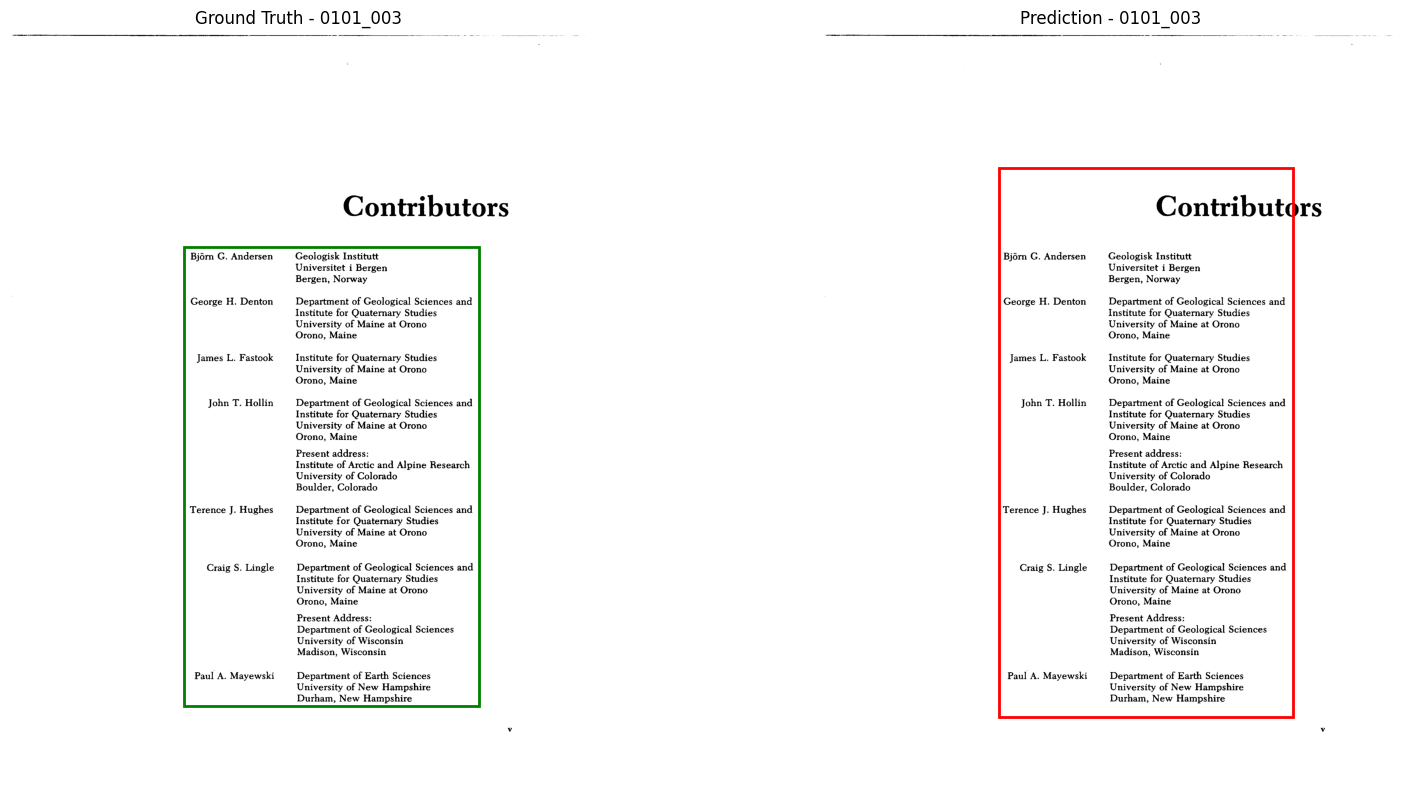

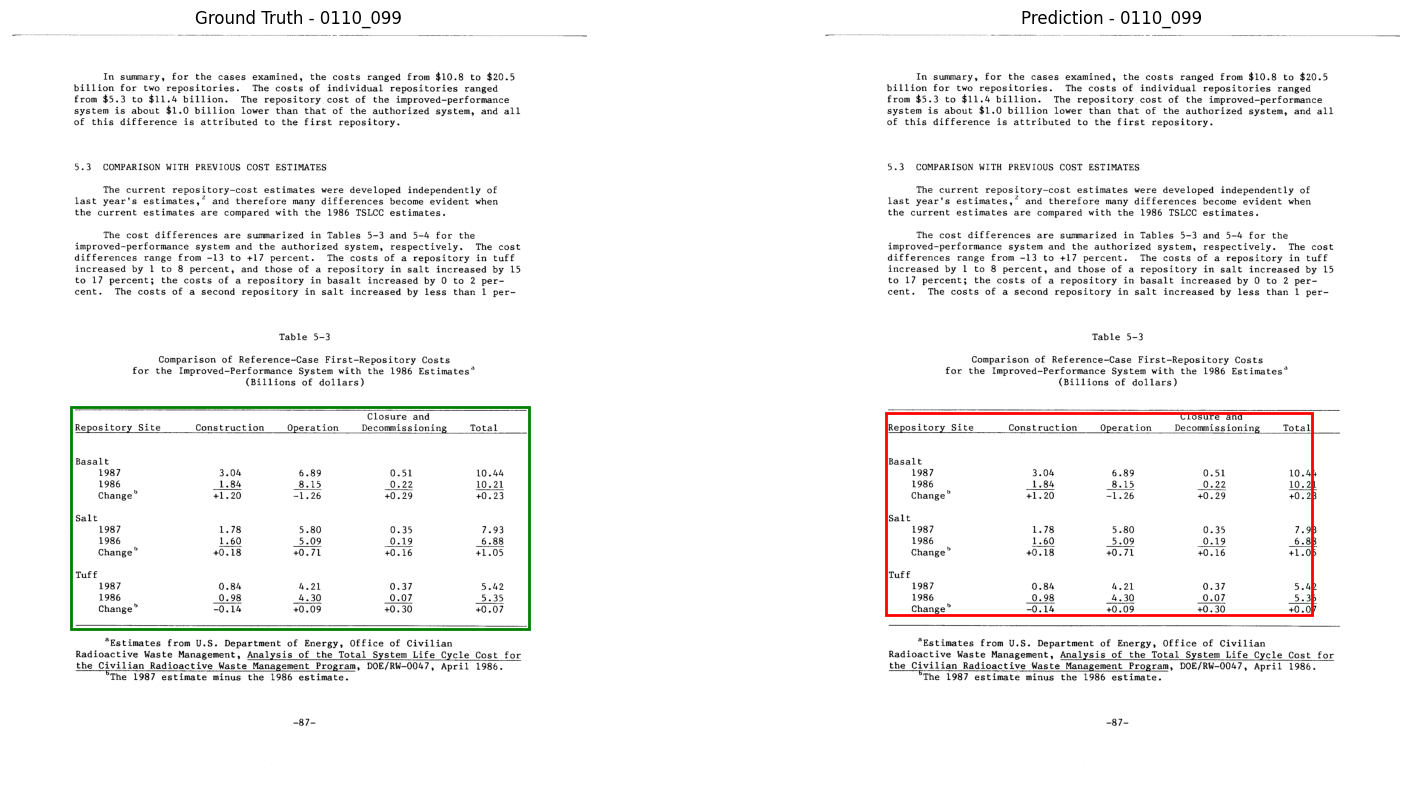

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize(image_path, gt_boxes, pred_boxes, image_id):
    img = Image.open(image_path)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Ground Truth
    ax1.imshow(img)
    for box in gt_boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="green", facecolor="none")
        ax1.add_patch(rect)
    ax1.set_title(f"Ground Truth - {image_id}")
    ax1.axis("off")

    # Predictions
    ax2.imshow(img)
    for box in pred_boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
        ax2.add_patch(rect)
    ax2.set_title(f"Prediction - {image_id}")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

# Example: visualize first available image
for image_id in test_df["image_id"].unique()[:3]:
    gt_rows = test_df[test_df["image_id"] == image_id].dropna(subset=["bbox"])
    if gt_rows.empty:
        continue
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(TEST_IMG_DIR, str(image_id) + ext)
        if os.path.exists(p):
            gt_boxes = [eval(r["bbox"]) for _, r in gt_rows.iterrows()]
            pred_boxes = predict_tables(p, model, processor, threshold=0.3)
            visualize(p, gt_boxes, pred_boxes, image_id)
            break